In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn.feature_selection import f_classif, f_regression, SelectKBest, chi2
from sklearn.ensemble          import IsolationForest

from sklearn.model_selection   import train_test_split
from sklearn.grid_search       import GridSearchCV
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_squared_error, mean_absolute_error, median_absolute_error

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import _pickle           as cPickle

import itertools
import argparse

from commonModel import loadCSVData, FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS, TARGET_COLUMN
from commonModel import limitDataUsingProcentiles, limitDataUsingLimitsFromFilename

dataFileName   = "input/NizhnyNovgorodWithYear.csv"
limitsFileName = "input/NizhnyNovgorodLimits.json"

#dataFileName   = "input/SaintPetersburg.csv"
#limitsFileName = "input/SaintPetersburgLimits.json"

#dataFileName   = "input/Moscow.csv"
#limitsFileName = "input/MoscowLimits.json"

allDataFrame = loadCSVData( dataFileName, COLUMN_TYPE='NUMERICAL' )
allDataFrame = limitDataUsingLimitsFromFilename( allDataFrame, limitsFileName )
allDataFrame = limitDataUsingProcentiles       ( allDataFrame )

#latitude  = 55.751999;longitude = 37.617734;
#latitude_s  = allDataFrame['latitude' ].values
#longitude_s = allDataFrame['longitude'].values
#allDataFrame['distance_from_kremlin'] = np.sqrt( (latitude_s - latitude)**2 + (longitude_s - longitude)**2 )
#allDataFrame = inputDataFrame[FEATURES]
allDataFrame.head(10)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/sergey/My_trash/GEO_GID/commonModel.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/i

,price,longitude,latitude,total_square,number_of_rooms,number_of_floors,exploitation_start_year,floor_flag
0,2850000.0,44.075417,56.283863,43.000000,1.0,17.0,2011.0,1
1,2600000.0,43.923782,56.310448,64.000000,4.0,5.0,1974.0,1
2,2750000.0,44.064953,56.291500,50.000000,2.0,5.0,1987.0,1
3,3700000.0,43.996544,56.317806,45.000000,2.0,8.0,1969.0,1
4,4760000.0,43.943588,56.294998,105.000000,4.0,9.0,1975.0,1
5,2960000.0,43.957848,56.333199,39.000000,1.0,9.0,2008.0,1
6,3400000.0,44.073002,56.283863,44.000000,1.0,17.0,2010.0,1
7,4000000.0,44.019955,56.321625,64.000000,3.0,9.0,1969.0,1
8,2500000.0,44.058098,56.299377,45.299999,2.0,9.0,1982.0,1
9,1600000.0,43.859066,56.251022,30.000000,1.0,9.0,1984.0,1


In [2]:
allDataFrame.describe()

,price,longitude,latitude,total_square,number_of_rooms,number_of_floors,exploitation_start_year,floor_flag
count,1.708200e+04,17082.000000,17082.000000,17082.000000,17082.000000,17082.000000,17082.000000,17082.0
mean,3.509846e+06,43.937695,56.300060,56.358776,2.130605,9.352242,1983.242432,1.0
std,2.048364e+06,0.079690,0.038497,24.661306,0.948335,5.032542,22.927679,0.0
min,5.500000e+05,43.739635,56.163158,13.000000,1.000000,2.000000,1898.000000,1.0
25%,2.270000e+06,43.866413,56.267857,40.500000,1.000000,5.000000,1967.000000,1.0
50%,2.990000e+06,43.935909,56.303593,51.200001,2.000000,9.000000,1982.000000,1.0
75%,4.190000e+06,44.006811,56.327808,67.000000,3.000000,10.000000,2006.000000,1.0
max,3.700000e+07,44.099152,56.391964,400.000000,9.000000,28.000000,2017.000000,1.0


In [3]:
import torch
import _pickle as cPickle
from commonModel import FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS

import warnings
warnings.filterwarnings('ignore')

NUMERICAL_COLUMNS = FLOAT_COLUMNS + INT_COLUMNS
testDataFrame = allDataFrame

FEATURES = list( testDataFrame.columns ); FEATURES.remove( TARGET_COLUMN )
COLUMNS  = list( testDataFrame.columns ); LABEL = TARGET_COLUMN;

device = torch.device('cpu')
#device = torch.device('cuda') # Uncomment this to run on GPU
Model         = None
Features      = None
preprocessorX = None
preprocessorY = None
with open( "modelNizhnyNovgorod.pkl", 'rb') as fid:
#with open( "modelSaintPetersburg.pkl", 'rb') as fid:
#with open( "modelMoscow.pkl", 'rb') as fid:
    ModelPacket = cPickle.load(fid)
    Model         = ModelPacket['model'        ]
    Features      = ModelPacket['features'     ]
    preprocessorX = ModelPacket['preprocessorX']
    preprocessorY = ModelPacket['preprocessorY']
index       = testDataFrame.index;
Y_dataFrame = testDataFrame    [[ TARGET_COLUMN ]];       
Y_values    = Y_dataFrame.values;
X_dataFrame = testDataFrame.drop( TARGET_COLUMN, axis=1); 
X_dataFrame = X_dataFrame[ Features ]

X_values    = X_dataFrame.values
Y_values    = Y_values

X_numpy = preprocessorX.transform( X_values )
Y_numpy = preprocessorY.transform( Y_values )

X_torch = torch.from_numpy( X_numpy.astype( np.float32 ) ).to( device )
Y_torch = Model( X_torch )
Y_predict = Y_torch.detach().numpy()

print( "Errors on the test set" )
print( "mean square:     ", mean_squared_error   ( Y_numpy, Y_predict ) )
print( "mean absolute:   ", mean_absolute_error  ( Y_numpy, Y_predict ) )
print( "median_absolute: ", median_absolute_error( Y_numpy, Y_predict ) )

Y_predict = preprocessorY.inverse_transform( Y_predict ).ravel()
Y_values  = Y_values.ravel()

print( "Errors on the test set" )
print( "mean square:     ", mean_squared_error   ( Y_values, Y_predict ) )
print( "mean absolute:   ", mean_absolute_error  ( Y_values, Y_predict ) )
print( "median_absolute: ", median_absolute_error( Y_values, Y_predict ) )

Errors on the test set
mean square:      0.002534824
mean absolute:    0.027041933
median_absolute:  0.014469087
Errors on the test set
mean square:      425096300000.0
mean absolute:    350193.0
median_absolute:  187374.75


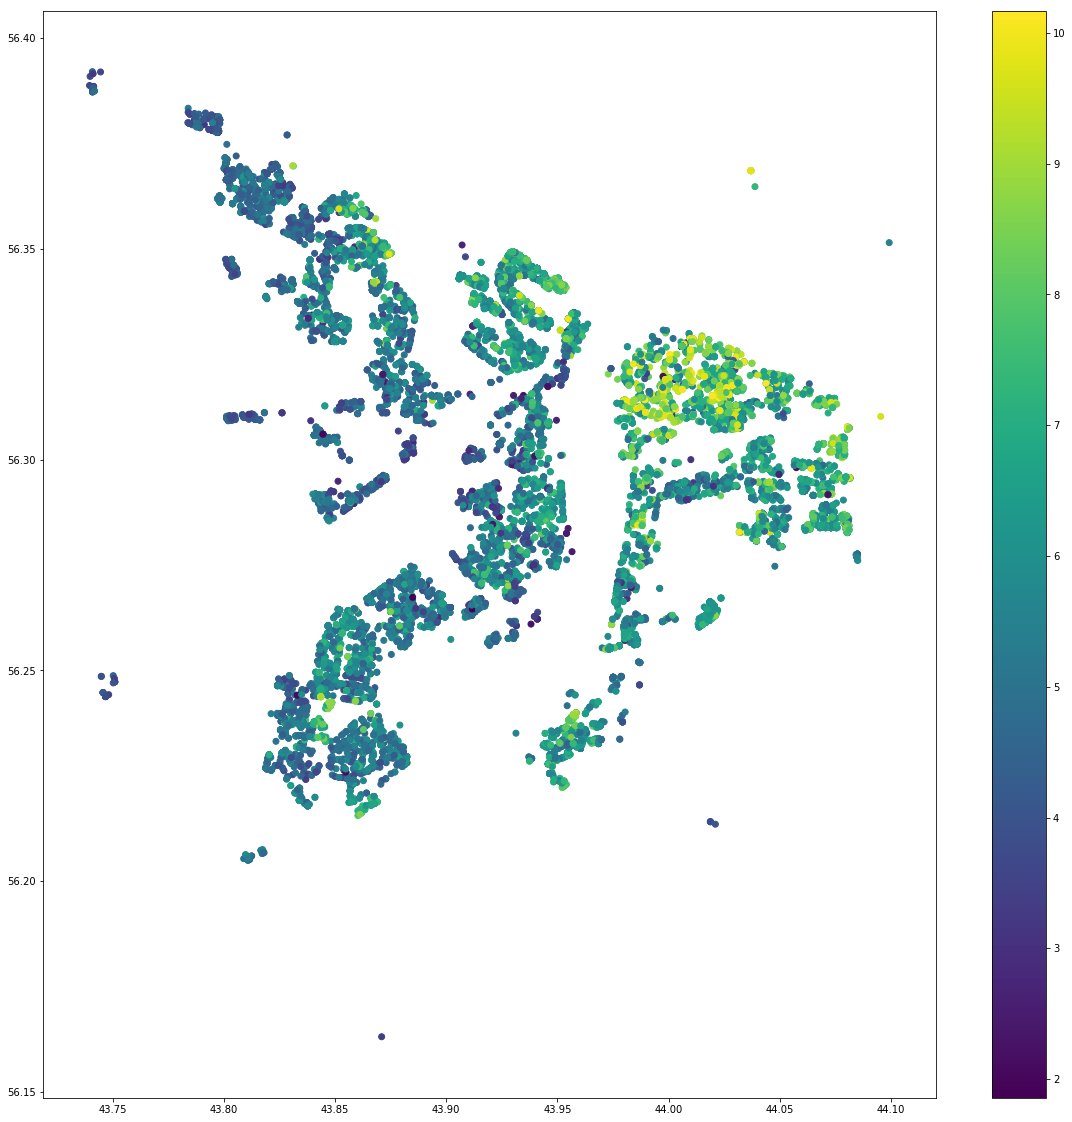

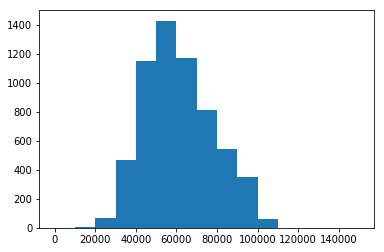

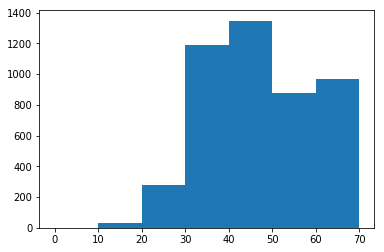

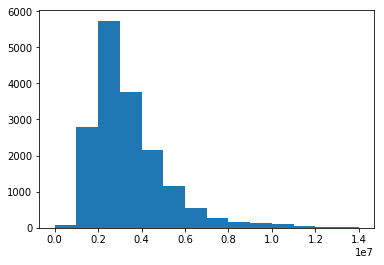

In [4]:
pricePerSquare       = allDataFrame['price']/allDataFrame['total_square']
TotalSquare          = allDataFrame['total_square']
Price                = allDataFrame['price']

pricePerSquareValues = pricePerSquare.values
TotalSquareValues    = TotalSquare.values
PriceValues          = Price.values

x = X_values[:,0]; y = X_values[:,1];

plt.figure(figsize=(20,20))
plt.scatter (x, y, c=pricePerSquareValues/10000  )
plt.colorbar()
plt.show()

Y_relErr = np.abs( Y_predict - Y_values )*100/Y_values
mask = Y_relErr > 10
pricePerSquareValues = pricePerSquareValues[ mask ]
TotalSquareValues    = TotalSquareValues   [ mask ]
Price                = Price               [ mask ]

bins = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.,15.]
bins = [i * 1e4 for i in bins]
plt.hist( pricePerSquareValues, bins=bins )
plt.show()

bins = [0,10,20,30,40,50,60,70]
plt.hist( TotalSquareValues, bins=bins )
plt.show()

bins = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.]
bins = [i * 1e6 for i in bins]
plt.hist( PriceValues      , bins=bins )
plt.show()


[ 3060536.8  2903266.5  2901923.8 ... 13547870.   2448492.2  3853320.5]
[ 2850000.  2600000.  2750000. ... 15700000.  2790000.  3841000.]
threshold =   2.5, good =       4530, bad =      12552, err = 0.7348085704250088
threshold =   5.0, good =       7255, bad =       9827, err = 0.5752839245989931
threshold =  10.0, good =      11024, bad =       6058, err = 0.3546423135464231
threshold =  15.0, good =      13458, bad =       3624, err = 0.21215314365999297


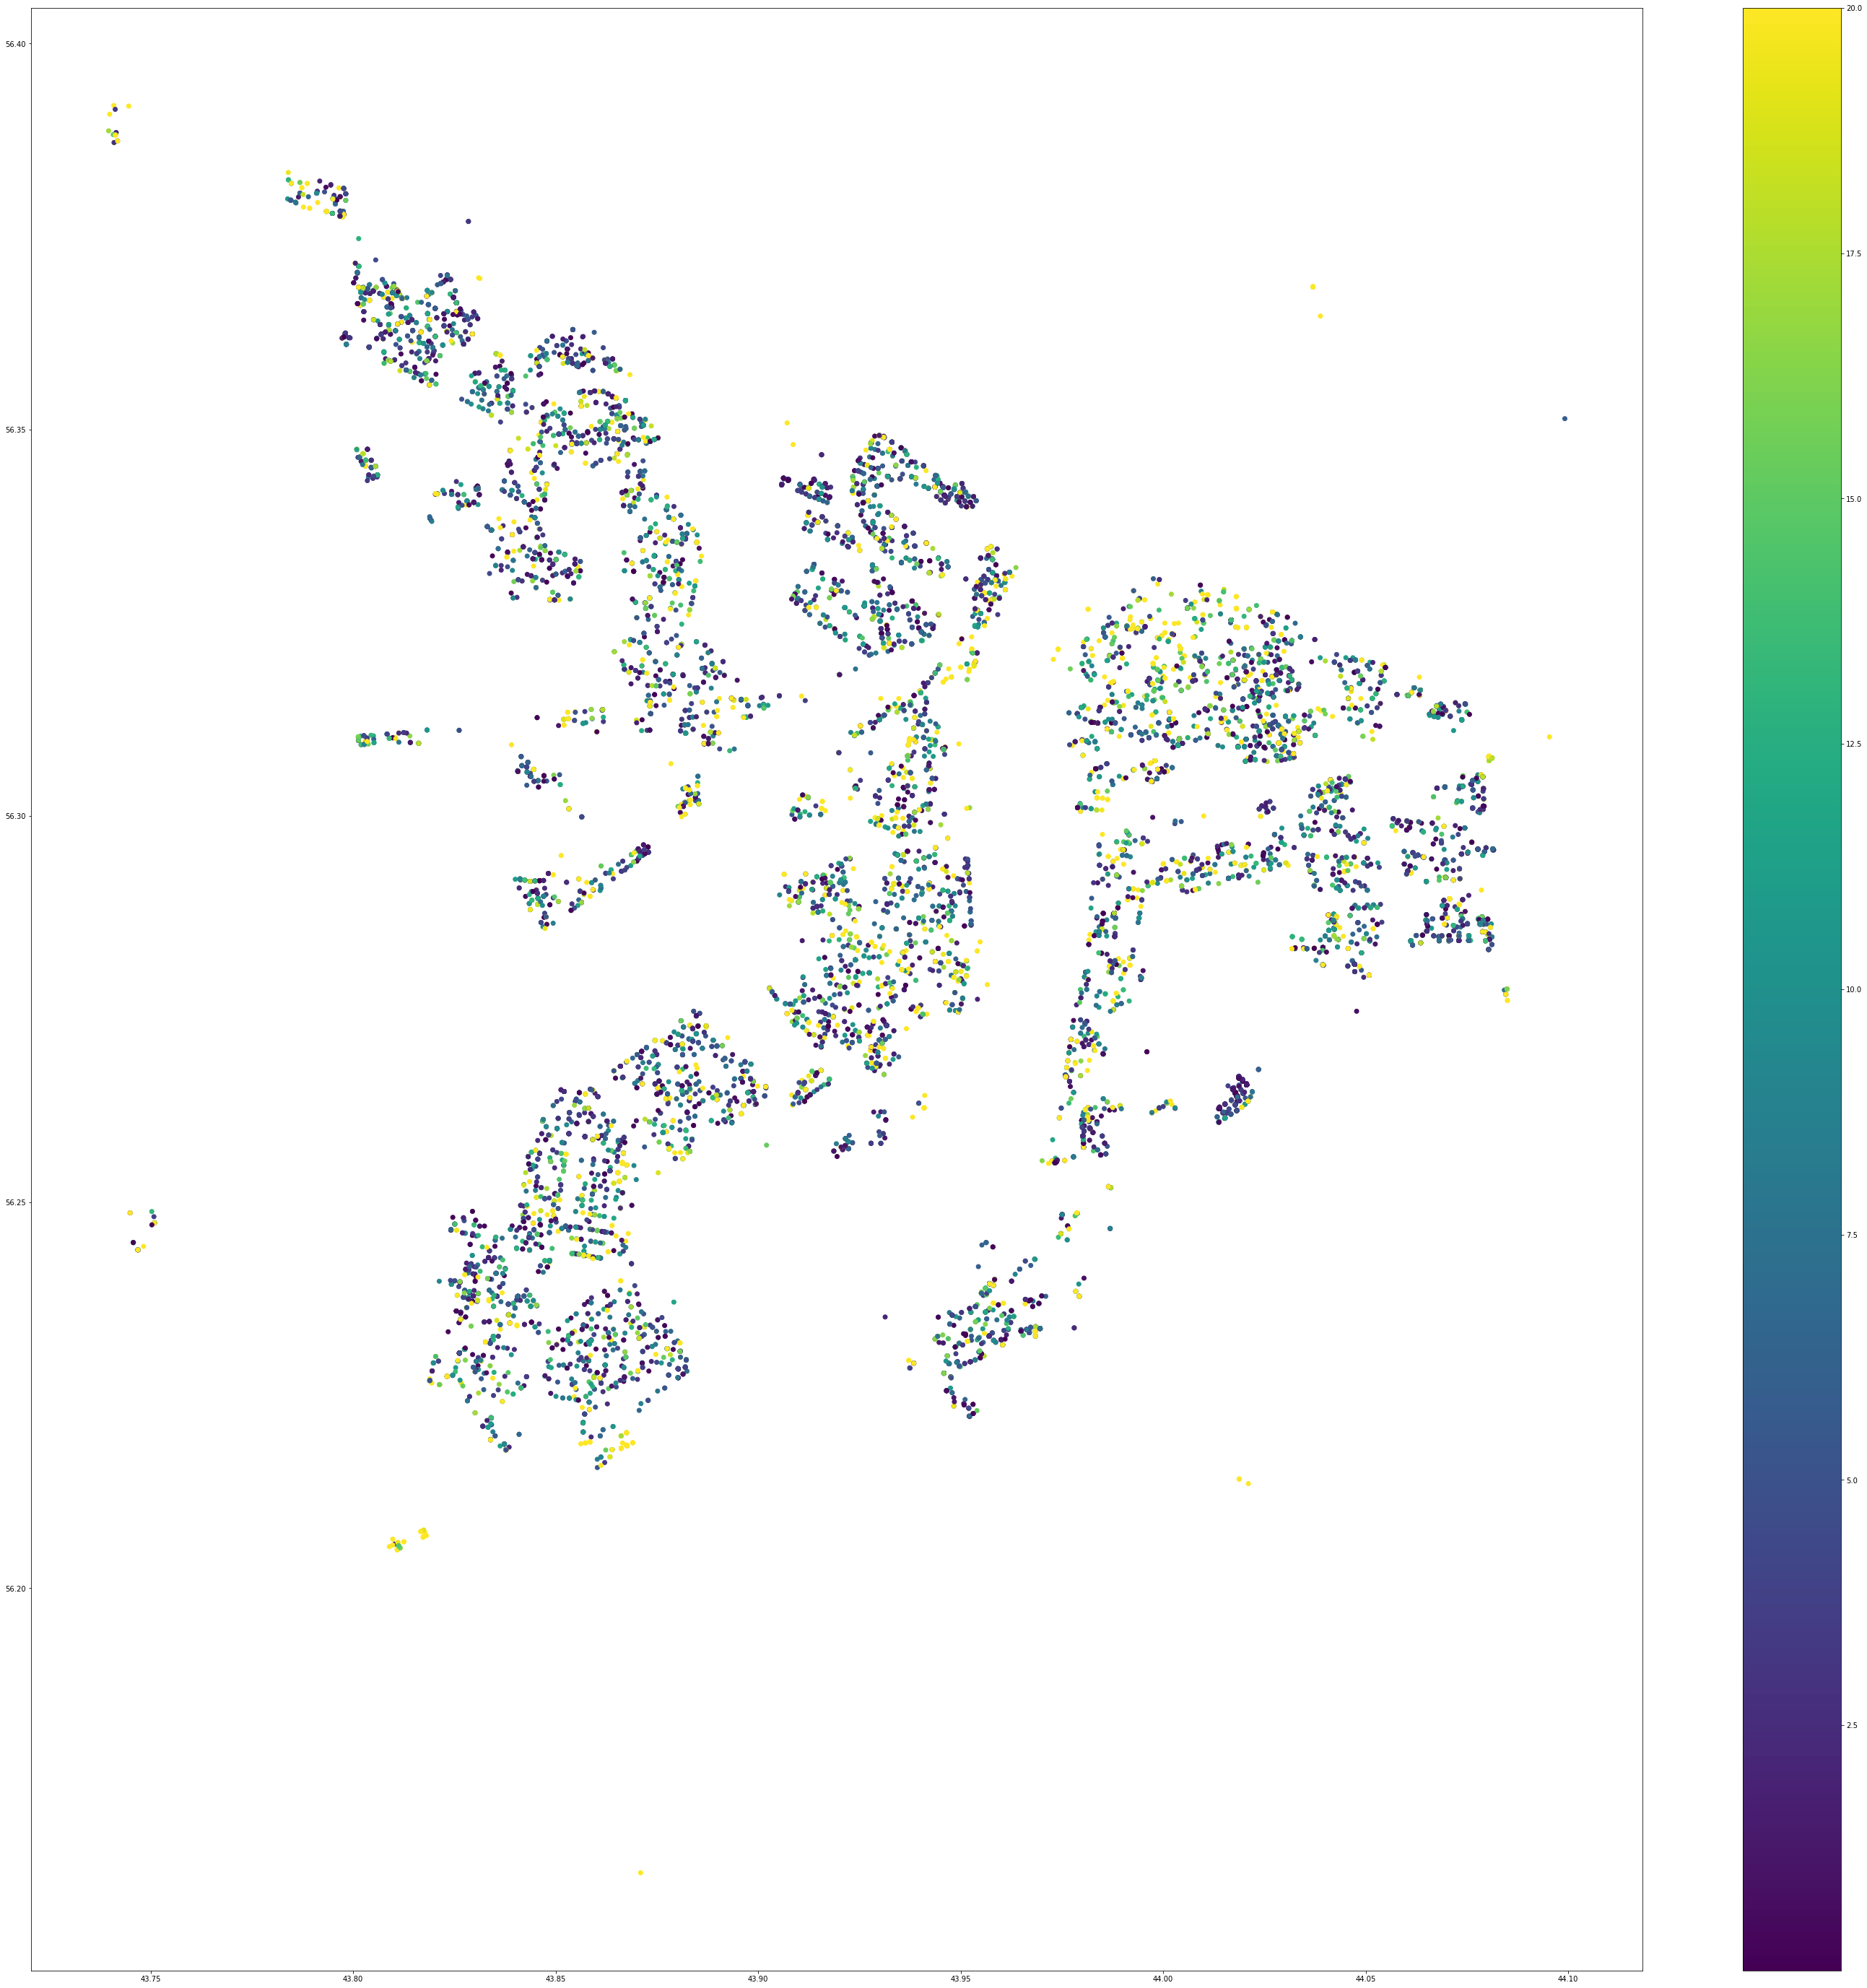

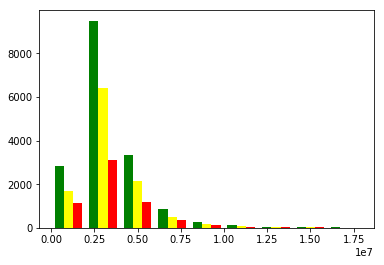

[2851 9499 3321  845  283  138   57   48   17]
[1696 6394 2154  475  165   80   22   15    7]
[1155 3105 1167  370  118   58   35   33   10]


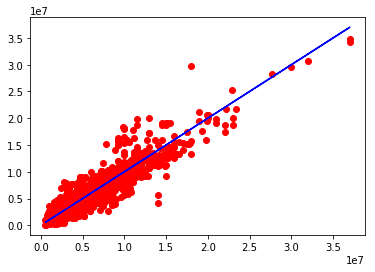

In [5]:
Y_predict = np.array( Y_predict )
Y_values  = np.array( Y_values  )

print( Y_predict )
print( Y_values  )

Y_relErr = np.abs( Y_predict - Y_values )*100/Y_values
for threshold in [ 2.5, 5.0, 10.0, 15.0 ]:
    bad_s  = np.sum( ( Y_relErr  > threshold ).astype( np.int ) )
    good_s = np.sum( ( Y_relErr <= threshold ).astype( np.int ) )
    print("threshold = {:5}, good = {:10}, bad = {:10}, err = {:4}".format( threshold, good_s, bad_s, bad_s/(good_s+bad_s)) )
x =  X_values[:,0]; y = X_values[:,1]; c = np.minimum(  Y_relErr, 20 );

plt.figure(figsize=(50,50))
plt.scatter (x, y, c=c  )
plt.colorbar()
plt.show()
"""
mask = ( Y_values < 1e6 ) & ( Y_relErr > 10 )
x_low = X_values[mask,0]; y_low = X_values[mask,1]; c_low = 'red'
plt.scatter (x_low, y_low, c=c_low, marker="*", s=75  )

mask = ( Y_values > 5e6 ) & ( Y_relErr > 10 )
x_high = X_values[mask,0]; y_high = X_values[mask,1]; c_high = 'aqua'
plt.scatter (x_high, y_high, c=c_high, marker="*", s=75  )
plt.show    ()
"""
threshold = 10
allTestDataValues  = testDataFrame.price.values
mask = Y_relErr >  threshold
badTestDataValues = testDataFrame[ mask ].price.values
mask = Y_relErr <= threshold
goodTestDataValues = testDataFrame[ mask ].price.values

bins = [0.,2.,4.,6.,8.,10.,12.,14.,16.,18]
bins = [i * 1e6 for i in bins]

n = plt.hist([ allTestDataValues, goodTestDataValues, badTestDataValues ], bins=bins, histtype='bar', color=['green','yellow','red'])
plt.show()

print( n[0][0].astype(np.int64) )
print( n[0][1].astype(np.int64) )
print( n[0][2].astype(np.int64) )

plt.scatter(Y_values,Y_predict, color='red' )
plt.plot   (Y_values,Y_values , color='blue')
plt.show   ()

In [6]:
from commonModel import MAX_LONGITUDE, MIN_LONGITUDE, MAX_LATITUDE, MIN_LATITUDE

import warnings
warnings.filterwarnings('ignore')

topK = 10

eps_x = ( MAX_LONGITUDE - MIN_LONGITUDE )*0.001
eps_y = ( MAX_LATITUDE  - MIN_LATITUDE  )*0.001
eps   = min( eps_x, eps_y )

topRelErrIndices = Y_relErr.argsort()[-topK:][::-1]
for i in topRelErrIndices :
    base_row = allDataFrame.iloc[ i ]
    base_x = base_row.longitude 
    base_y = base_row.latitude  
    print("BASE record")
    print( base_row )
    
    for index, cand_row in allDataFrame.iterrows():
        cand_x = cand_row.longitude
        cand_y = cand_row.latitude
        
        distance = np.sqrt( (cand_x-base_x)*(cand_x-base_x) + (cand_y-base_y)*(cand_y-base_y) )
        if distance < eps :
            print("CLOSEST record")
            print( cand_row )
    print("")
    

ImportError: cannot import name 'MAX_LONGITUDE'